In [27]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

import matplotlib
matplotlib.rcParams.update({"text.usetex": True, "font.family": "Times"})

In [28]:
from gen_data import CartPoleDynamics

In [43]:
models = pickle.load(open("trained-model.pkl", "rb"))
model = models[2]["model"]

In [44]:
with open("../data/data.csv", "r") as f:
    params = dict([(param, float(val)) for (param, val) in [pair.split('=') for pair in f.readline().split(',')]])

In [45]:
dt = 1. / 30.

dyn = CartPoleDynamics(*params.values())

np.random.seed(0)

sims = []
for _ in tqdm(range(500)):
    x0 = np.array([np.random.uniform(-2, 2), 
                   np.random.uniform(-np.pi/16, np.pi/16),
                   np.random.uniform(-0.1, 0.1),
                   np.random.uniform(-np.pi/16, np.pi/16)])
    x = x0
    x_df = pd.DataFrame(x.reshape(1, -1), columns=["z", "theta", "z_dot", "theta_dot"])

    x_arr = []
    
    t = 0.
    while t < 2:
        x_df[:] = x.reshape(1, -1)
        u = np.clip(model.predict(x_df), -10., 10.) + np.random.normal(0., 0.1)
        dxdt = dyn.f(t, x, u)
        x += dxdt * dt
        x_arr.append(x.copy())
        t += dt
    
    sims.append(x_arr.copy())

100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


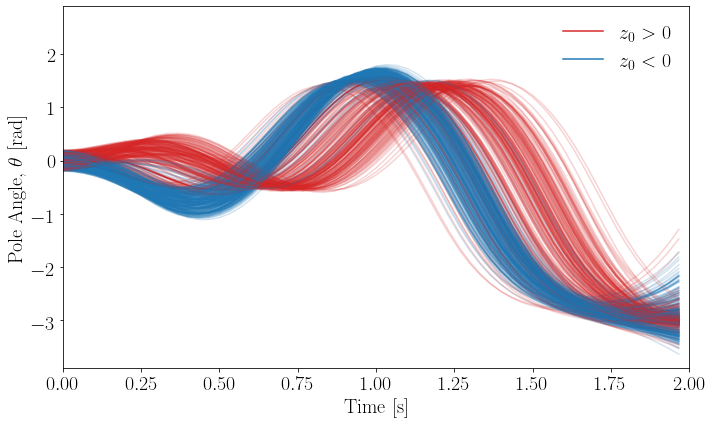

In [47]:
plt.figure(figsize=(10,6))
for x_arr in sims:
    plt.plot(dt * np.arange(len(x_arr)), [x[1] for x in x_arr], alpha=0.2, color="tab:red" if x_arr[0][0] > 0 else "tab:blue",
             label=r"$z_{0} > 0$" if x_arr[0][0] > 0 else r"$z_{0} < 0$")
plt.xlim(0, 2)
plt.ylim(-3.9, 2.9)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
handles, labels = plt.gca().get_legend_handles_labels()
for i in [0, 1]:
    handles[i].set_alpha(1)
plt.legend(handles[:2], labels[:2], fontsize=20, frameon=False)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel(r"Pole Angle, $\theta$ [rad]", fontsize=20)
plt.tight_layout()
plt.savefig("../figures/model/evaluation.png", dpi=500)